<a href="https://colab.research.google.com/github/hydanggia2899/Shopee_ProductDetection/blob/master/Shopee_Week2_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopee Week 2 - Product Detection

## 1.Install Libraries and download the dataset

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from torch.utils.data.dataset import Dataset
import numpy as np
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.notebook import tqdm

In [ ]:
#Download the dataset by GDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '13Kwb-19DS9CLSUOMokhsjKtutQXSDUT5'})
download.GetContentFile('shopee_new.zip')

In [ ]:
!7za x shopee_new.zip -o\dataset


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 10069790881 bytes (9604 MiB)

Extracting archive: shopee_new.zip
  3% 4096 Open              --
Path = shopee_new.zip
Type = zip
Physical Size = 10069790881
64-bit = +

  0%      0% 87 - test/test/01f0743df9e81bb686f95ffe4ec21d6c.jpg                                                          0% 182 - test/test/0459bc8387d989335d6d340a2fd04a72.jpg                                                           0% 261 - test/test/05b6e18330a285728debceecfa849e14.jp

### Remove Extra Images if possible

In [ ]:
path = "dataset/"
TRAIN_PATH = path + "train/train/"
TEST_PATH =path + "test/test/"

In [ ]:
def remove_extra(path_csv,path_files):
  #Check folder contains enough dataset
  import glob
  import os.path as osp
  test_sum = pd.read_csv(path_csv)
  list_test = glob.glob(path_files+ "*.jpg")
  for index,item in enumerate(list_test):
    list_test[index] = osp.basename(item)
  #print(list_test)
  count = 0
  extra_file = list()
  for file in (list_test):
    if(file not in test_sum["filename"].tolist()):
      count+=1
      extra_file.append(file)
  print(extra_file)
  #Remove extra file
  import os
  count = 0
  for filename in extra_file:
    os.remove(path_files + filename)
    print("File Removed!")
    count +=1
  print(count)

In [ ]:
#Remove extra
remove_extra(path + "test.csv",path + "test/test/")

[]
0


## 2. Work with the dataset

In [ ]:
class ShopeeDataset(Dataset):
    def __init__(self,directory,transform,train=True):
        self.transform = transform                      # function that turns an image into a tensor that can be passed to the pytorch model
        self.img_ls = list()                            # where the path to each training image file is stored

        classes = ["%.2d" % i for i in range(len(os.listdir(directory)))]           # ['00','01',...,'41'] i.e. the folders for the images of each corresponding category
        for clas in classes:
            
            path = os.path.join(directory,clas)
            ls = sorted(os.listdir(path))               # obtain list of image file names in a class folder
            valid_partition = round(len(ls)*0.2)
            if train:
                for img_name in ls[:-valid_partition]:                                           # take all images except the last 50 images for each category. This will be used as training data
                    self.img_ls.append((os.path.join(path,img_name),int(clas)))     # adds to img_ls in a tuple format (path,category)
            else:
                for img_name in ls[-valid_partition:]:                                           # last 50 images of each category for validation set, for monitoring of current performance
                    self.img_ls.append((os.path.join(path,img_name),int(clas)))
        
    def __getitem__(self, idx):                         # this function will be called by pytorch dataloader class.
        name, label = self.img_ls[idx]
        img = Image.open(name).convert('RGB')           # load image
        img.load()
        img = self.transform(img)                       # apply transformation to turn image into torch tensor
        return {"image": img, "label": label}
    
    def __len__(self):                                  # allows usage of len(<name of dataset>) to obtain size of entire dataset
        return len(self.img_ls)

In [ ]:
def train_epoch(model,  trainloader,  criterion, device, optimizer):


    model.train()
    losses = list()
    ct=0
    for batch_idx, data in enumerate(tqdm(trainloader)):       #iterate through dataset. tqdm is the loading bar, allows you to track progress
        ct+=1
        inputs=data['image'].to(device)                 # images
        labels=data['label'].to(device)                 # labels
        optimizer.zero_grad()
        outputs = model(inputs)                         # prediction
        loss = criterion(outputs, labels)               # loss function, tells you how "wrong" your predictions are based on the training dataset.
        loss.backward()                                 # backpropogation
        optimizer.step()                                # gradient descent
        losses.append(loss.item())
        
    print('Loss: Training', sum(losses)/ct, "\n") 
    return sum(losses)/ct

In [ ]:
def evaluate(model, dataloader, device):

    model.eval()                                                    # set model to evaluation mode
    total=0                                                         # store total number of validation samples
    correct = 0                                                     # store total number of correct prediction samples
    with torch.no_grad():
      for ctr, data in enumerate(dataloader):
          inputs = data['image'].to(device)                         # obtain validation images
          outputs = model(inputs)                                   # pass images to model
          labels = data['label']                                    # actual labels for validation images. Also known as ground truth
          labels = labels.float()
          cpuout= outputs.to('cpu')
          total += len(labels)                                      # total number of samples

          pred = cpuout.argmax(dim=1, keepdim=True)                 # for each sample, the model gives a score for each category. Choose the category that contains the highest score as the prediction
          correct += pred.eq(labels.view_as(pred)).sum().item()     # number of correct predictions

      accuracy = correct / total                                    # accuracy = total correct / total number of samples

    return accuracy

In [ ]:
def train_modelcv(dataloader_cvtrain, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device):

  for epoch in range(num_epochs):                                                           # iterates through specified number of epochs
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train(True)                                                                           
    train_loss=train_epoch(model,  dataloader_cvtrain,  criterion,  device , optimizer )    # train model

    model.train(False)
    measure = evaluate(model, dataloader_cvtest, device)                                    # evaluate model
    #measure2 = evaluate(model, dataloader_cvtrain, device) 
    print('Top 1 Accuracy validation:', measure, "\n") 
    #print('Top 1 Accuracy train:',measure2,"\n")                                                # print accuracy for current epoch
  return None

## 3. Train model. 
#### Resnet 18


In [ ]:
from collections import OrderedDict
batchsize=64                                                            # number of images being passed to the model at any one time. If you face cuda memory error, reduce batchsize.
lr = 0.0001                                                               # how "fast" you want your model to learn. Very important to play around with different values.

data_transform = transforms.Compose([transforms.Resize((224,224)),      # images are of different size, reshape them to same size. Up to you to decide what size to use.
                                     transforms.RandomCrop(size=(224,224),padding=(10,10)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(degrees=15,fill=0),
                                     transforms.ToTensor(),             # convert image to torch tensor
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])   # normalizing images helps improve convergence

                                                # where your training images are
dataset_train = ShopeeDataset(TRAIN_PATH, data_transform,train=True)          # training dataset
dataset_valid = ShopeeDataset(TRAIN_PATH, data_transform,train=False)         # validation dataset to measure current model performance. (rough gauge)

loadertr=torch.utils.data.DataLoader(dataset_train,batch_size=batchsize,shuffle=True)       # dataloader for training set
loaderval=torch.utils.data.DataLoader(dataset_valid,batch_size=batchsize,shuffle=True)      # dataloader for validation set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # which device to use. If GPU is detected, use GPU, else, use CPU
criterion = nn.CrossEntropyLoss()                                       # Loss function
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

vgg = models.vgg19(pretrained=True)                                # transfer learning, Pytorch has a pretrained model trained on ImageNet. Turn this off if you want to, it may or may not help in the end. Helps achieve higher accuracy with less epochs though
ct = 0
for param in vgg.features.parameters(): 
  param.requires_grad = False
fc = nn.Sequential(OrderedDict([('fc1',nn.Linear(4096,2048)),('relu', nn.ReLU()),('fc2',nn.Linear(2048,42)),('output',nn.LogSoftmax(dim=1))]))                               # transfer learning, Pytorch has a pretrained model trained on ImageNet. Turn this off if you want to, it may or may not help in the end. Helps achieve higher accuracy with less epochs though
vgg.fc = fc                                     # as we only have 42 classes, change the last layer to predict on 42 classes.
vgg.to(device)                                         # as we only have 42 classes, change the last layer to predict on 42 classes.
                                                      # send model to device, and hopefully your device is GPU

optimizer = torch.optim.Adam(vgg.parameters(), lr=lr, weight_decay=5e-4)
maxnumepochs=15                                                        # number of epochs to train on. Should most definitely increase this to train more.
train_modelcv(dataloader_cvtrain = loadertr,                            # lets start training
              dataloader_cvtest = loaderval,  
              model = vgg,  
              criterion = criterion, 
              optimizer = optimizer,
              scheduler = None,
              num_epochs = maxnumepochs,
              device = device)

----------
Epoch 0/14
----------



Loss: Training 1.8758156392751586 

Top 1 Accuracy validation: 0.6228061853714069 

----------
Epoch 1/14
----------


In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from torch.utils.data.dataset import Dataset
class ShopeeTestDataset(Dataset):
    def __init__(self,directory,transform):
        self.transform = transform
        self.img_ls = list()

        ls = sorted(os.listdir(directory))
        for img_name in ls:
            self.img_ls.append((os.path.join(directory,img_name)))
        
    def __getitem__(self, idx):
        name = self.img_ls[idx]
        img = Image.open(name).convert('RGB')
        img.load()
        img = self.transform(img)
        return img,name[12:]
    
    def __len__(self):
        return len(self.img_ls)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def inference(model, dataloader, device):
    # df = pd.DataFrame()
    path_ls = list()
    pred_ls = list()
    model.eval()
    with torch.no_grad():
      for ctr, data in enumerate(dataloader):
          inputs,path = data
          inputs = inputs.to(device)
          outputs = model(inputs)
          cpuout= outputs.to('cpu')
          pred = cpuout.argmax(dim=1).numpy()
          path_ls += list(path)
          pred_ls += list(pred)
    df = pd.DataFrame({'filename':path_ls,'category':pred_ls})

    return df

In [ ]:
import torch
test_dataset = ShopeeTestDataset("dataset/test/test", data_transform)
loaderte=torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=False)
df = inference(vgg,loaderte,device)                               # predictions are stored in this dataframe
df.to_csv("test_prediction.csv",index=False)      # export dataframe as csv. It will export to your Google drive home folder

In [ ]:
import pandas as pd 
import numpy as np
#test = pd.read_csv("test.csv")
predict = pd.read_csv("test_prediction.csv")

In [ ]:
len(predict)

12186

In [ ]:
for i in range(0,len(predict["filename"])):
  predict["filename"][i] = predict["filename"][i].replace("/test/","")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
predict.to_csv("submit_2.csv",index = False)

(array([1513., 1138., 1097., 1110., 1068., 1122., 1213., 1370.,  936.,
        1619.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

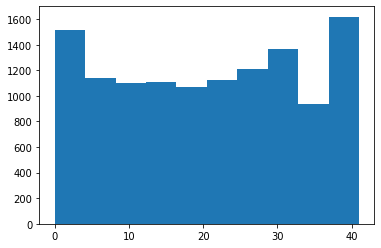

In [ ]:
plt.hist(predict["category"])

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '11iNqRY92oHAL-iEQQN2e_SRq74OCVJSp'})
download.GetContentFile('vgg.zip')

In [ ]:
!7za x vgg.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 568472495 bytes (543 MiB)

Extracting archive: vgg.zip
--
Path = vgg.zip
Type = zip
Physical Size = 568472495

  0%      3% 1 - vgg16_weights_tf_dim_ordering_tf_kernels.h5                                                      6% 1 - vgg16_weights_tf_dim_ordering_tf_kernels.h5                                                     10% 1 - vgg16_weights_tf_dim_ordering_tf_kernels.h5                                                    

In [ ]:
TRAIN_PATH = "dataset/train/train/"
TEST_PATH = "dataset/test/test/"
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
directory=TRAIN_PATH,
subset = 'training',
target_size=(224, 224),
batch_size=64,
class_mode="categorical",
shuffle=True,
seed = 42,
)
valid_generator = train_datagen.flow_from_directory(
directory=TRAIN_PATH,
subset = 'validation',
target_size=(224, 224),
batch_size=64,
class_mode="categorical",
shuffle=True,
seed = 42,
)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

#train_generator = random_crop(train_generator,10)
#valid_generator = random_crop(valid_generator,10)


Found 84331 images belonging to 42 classes.
Found 21061 images belonging to 42 classes.


In [ ]:
from keras.applications import VGG16
from keras.layers import Activation, Dense,GlobalAveragePooling2D
import keras.layers as layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import keras
local_weights_file = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = VGG16(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

pre_trained_model.load_weights(local_weights_file)
pre_trained_model.summary()
last_layer = pre_trained_model
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)    
#x = layers.Dense(512, activation='softmax')(x)                     
x = layers.Dense(42, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer =  keras.optimizers.Adam(lr=0.0001), 
            loss = 'categorical_crossentropy', 
            metrics = ['categorical_accuracy'])
es = keras.callbacks.EarlyStopping(monitor='max', mode='', verbose=1,patience = 4)
mc = ModelCheckpoint('best_model_inception.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model

history=model.fit_generator(train_generator,steps_per_epoch = STEP_SIZE_TRAIN,validation_data = valid_generator,validation_steps = STEP_SIZE_VALID,epochs=20,callbacks=[es,mc])

# pre_trained_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:788: RuntimeWarning: EarlyStopping mode  is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
torch.save(vgg.state_dict(),"vgg.pth")

In [ ]:
torch.save(vgg,"vgg_2.pth")

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1